In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from itertools import chain

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
solar = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/elecsim/data/processed/capacity_factor/Solar/ninja_pv_country_GB_merra-2_corrected.csv')
wind = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/elecsim/data/processed/capacity_factor/Wind/ninja_wind_country_GB_current-merra-2_corrected.csv')
demand = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/elecsim/data/processed/electricity_demand/uk_all_year_demand.csv')
wind.head()

,Unnamed: 0,time,national,offshore,onshore
0,0,01/01/1980 00:00,0.2024,0.2858,0.1496
1,1,01/01/1980 01:00,0.2016,0.2827,0.1502
2,2,01/01/1980 02:00,0.2015,0.2852,0.1485
3,3,01/01/1980 03:00,0.2032,0.2920,0.1470
4,4,01/01/1980 04:00,0.2090,0.3039,0.1489


## Data Munging and Feature Engineering

In [3]:
onshore = wind[['time','onshore']]
offshore = wind[['time','offshore']]
offshore.head()

,time,offshore
0,01/01/1980 00:00,0.2858
1,01/01/1980 01:00,0.2827
2,01/01/1980 02:00,0.2852
3,01/01/1980 03:00,0.2920
4,01/01/1980 04:00,0.3039


In [4]:
solar = solar.rename(columns={'pv':'value'})
offshore = offshore.rename(columns={'offshore':'value'})
onshore = onshore.rename(columns={'onshore':'value'})
demand = demand.rename(columns={'timestamp':'time','demand':'value'})
onshore.head()

,time,value
0,01/01/1980 00:00,0.1496
1,01/01/1980 01:00,0.1502
2,01/01/1980 02:00,0.1485
3,01/01/1980 03:00,0.1470
4,01/01/1980 04:00,0.1489


In [5]:
def to_datetime(dat, col_to_datetime):
    dat[col_to_datetime] = pd.to_datetime(dat[col_to_datetime])
    return dat


In [6]:
offshore = to_datetime(offshore, 'time')
onshore = to_datetime(onshore, 'time')
solar = to_datetime(solar, 'time')
demand = to_datetime(demand, 'time')

In [7]:
def get_hour(dat, datetime):
    hour_series = dat[datetime].dt.hour
    return hour_series
    


In [8]:
offshore['hour'] = get_hour(offshore, 'time')
onshore['hour'] = get_hour(onshore, 'time')
solar['hour'] = get_hour(solar, 'time')
demand['hour'] = get_hour(demand, 'time')
demand.head()

,time,value,hour
0,2011-05-27 16:00:00,38649.090909,16
1,2011-05-27 17:00:00,37497.583333,17
2,2011-05-27 18:00:00,36146.333333,18
3,2011-05-27 19:00:00,34741.166667,19
4,2011-05-27 20:00:00,34722.666667,20


In [9]:
def get_month(dat, datetime):
    month_series = dat[datetime].dt.month
    return month_series

In [10]:
offshore['month'] = get_month(offshore, 'time')
onshore['month'] = get_month(onshore, 'time')
solar['month'] = get_month(solar, 'time')
demand['month'] = get_month(demand, 'time')

demand.head()

,time,value,hour,month
0,2011-05-27 16:00:00,38649.090909,16,5
1,2011-05-27 17:00:00,37497.583333,17,5
2,2011-05-27 18:00:00,36146.333333,18,5
3,2011-05-27 19:00:00,34741.166667,19,5
4,2011-05-27 20:00:00,34722.666667,20,5


In [11]:
def get_dayofweek(dat, datetime):
    dayofweek_series = dat[datetime].dt.dayofweek
    return dayofweek_series

In [12]:
offshore['dayofweek'] = get_dayofweek(offshore, 'time')
onshore['dayofweek'] = get_dayofweek(onshore, 'time')
solar['dayofweek'] = get_dayofweek(solar, 'time')
demand['dayofweek'] = get_dayofweek(demand, 'time')

solar.head()

,time,value,hour,month,dayofweek
0,1985-01-01 00:00:00,0.0,0,1,1
1,1985-01-01 01:00:00,0.0,1,1,1
2,1985-01-01 02:00:00,0.0,2,1,1
3,1985-01-01 03:00:00,0.0,3,1,1
4,1985-01-01 04:00:00,0.0,4,1,1


In [13]:
def get_dayofmonth(dat, datetime):
    dayofmonth_series = dat[datetime].dt.day
    return dayofmonth_series

In [14]:
offshore['dayofmonth'] = get_dayofmonth(offshore, 'time')
onshore['dayofmonth'] = get_dayofmonth(onshore, 'time')
solar['dayofmonth'] = get_dayofmonth(solar, 'time')
demand['dayofmonth'] = get_dayofmonth(demand, 'time')

solar.head()

,time,value,hour,month,dayofweek,dayofmonth
0,1985-01-01 00:00:00,0.0,0,1,1,1
1,1985-01-01 01:00:00,0.0,1,1,1,1
2,1985-01-01 02:00:00,0.0,2,1,1,1
3,1985-01-01 03:00:00,0.0,3,1,1,1
4,1985-01-01 04:00:00,0.0,4,1,1,1


In [15]:
def get_lags(dat, value, col_prefix='value', lags=None):
    if lags == None:
        previous_three_hours = [1,2,3]
        previous_day = [24,25,26,27]
        previous_week = [168,169,170,171]
        lags = previous_three_hours + previous_day + previous_week
    else:
        lags=lags
    
    new_cols = dat.assign(**{f'{col_prefix}-{lag}': dat[value].shift(lag) for lag in lags})
    return new_cols

In [16]:
offshore = get_lags(offshore, 'value')
onshore = get_lags(onshore, 'value')
solar = get_lags(solar, 'value')
demand = get_lags(demand, 'value')
solar.head()

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171
0,1985-01-01 00:00:00,0.0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985-01-01 01:00:00,0.0,1,1,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985-01-01 02:00:00,0.0,2,1,1,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985-01-01 03:00:00,0.0,3,1,1,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985-01-01 04:00:00,0.0,4,1,1,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
offshore = offshore.dropna()
onshore = onshore.dropna()
solar = solar.dropna()
demand = demand.dropna()
demand

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171
171,2011-06-03 19:00:00,33880.250000,19,6,4,3,35690.250000,36978.333333,38135.416667,35907.000000,37420.250000,38815.583333,39945.250000,34741.166667,36146.333333,37497.583333,38649.090909
172,2011-06-03 20:00:00,33181.000000,20,6,4,3,33880.250000,35690.250000,36978.333333,35405.833333,35907.000000,37420.250000,38815.583333,34722.666667,34741.166667,36146.333333,37497.583333
173,2011-06-03 21:00:00,33132.083333,21,6,4,3,33181.000000,33880.250000,35690.250000,35090.250000,35405.833333,35907.000000,37420.250000,33434.833333,34722.666667,34741.166667,36146.333333
174,2011-06-03 22:00:00,30041.916667,22,6,4,3,33132.083333,33181.000000,33880.250000,31313.083333,35090.250000,35405.833333,35907.000000,29708.750000,33434.833333,34722.666667,34741.166667
175,2011-06-03 23:00:00,27883.666667,23,6,4,3,30041.916667,33132.083333,33181.000000,29467.250000,31313.083333,35090.250000,35405.833333,27410.000000,29708.750000,33434.833333,34722.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66502,2018-12-27 14:00:00,36784.750000,14,12,3,27,36682.000000,36814.166667,36714.583333,32605.500000,32773.250000,32548.916667,31786.916667,39188.750000,38287.500000,38239.750000,38465.000000
66503,2018-12-27 15:00:00,37835.750000,15,12,3,27,36784.750000,36682.000000,36814.166667,33133.333333,32605.500000,32773.250000,32548.916667,40193.583333,39188.750000,38287.500000,38239.750000
66504,2018-12-27 16:00:00,40393.583333,16,12,3,27,37835.750000,36784.750000,36682.000000,35031.833333,33133.333333,32605.500000,32773.250000,42569.583333,40193.583333,39188.750000,38287.500000
66505,2018-12-27 17:00:00,42150.583333,17,12,3,27,40393.583333,37835.750000,36784.750000,36038.833333,35031.833333,33133.333333,32605.500000,44252.916667,42569.583333,40193.583333,39188.750000


In [18]:
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

class EnglandAndWalesHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=next_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May bank holiday',
                month=5, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('Spring bank holiday',
                month=5, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Summer bank holiday',
                month=8, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Christmas Day', month=12, day=25, observance=next_monday),
        Holiday('Boxing Day',
                month=12, day=26, observance=next_monday_or_tuesday)
    ]

def check_if_holiday(dat, datetime):
    cal = EnglandAndWalesHolidayCalendar()
    
    holidays = cal.holidays(start=dat[datetime].min(), end=dat[datetime].max())

    dat['holiday'] = dat['time'].dt.date.astype('datetime64').isin(holidays)
    return dat

In [19]:
solar = check_if_holiday(solar, 'time')
offshore = check_if_holiday(offshore, 'time')
onshore = check_if_holiday(onshore, 'time')
demand = check_if_holiday(demand, 'time')

In [20]:
onshore.head()

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171,holiday
171,1980-08-01 03:00:00,0.2022,3,8,4,1,0.1860,0.1758,0.1756,0.1765,0.1722,0.1702,0.1805,0.1470,0.1485,0.1502,0.1496,False
172,1980-08-01 04:00:00,0.2165,4,8,4,1,0.2022,0.1860,0.1758,0.1778,0.1765,0.1722,0.1702,0.1489,0.1470,0.1485,0.1502,False
173,1980-08-01 05:00:00,0.2146,5,8,4,1,0.2165,0.2022,0.1860,0.1751,0.1778,0.1765,0.1722,0.1483,0.1489,0.1470,0.1485,False
174,1980-08-01 06:00:00,0.2028,6,8,4,1,0.2146,0.2165,0.2022,0.1683,0.1751,0.1778,0.1765,0.1475,0.1483,0.1489,0.1470,False
175,1980-08-01 07:00:00,0.1967,7,8,4,1,0.2028,0.2146,0.2165,0.1654,0.1683,0.1751,0.1778,0.1486,0.1475,0.1483,0.1489,False


In [21]:
offshore.head()

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171,holiday
171,1980-08-01 03:00:00,0.2285,3,8,4,1,0.2170,0.2067,0.2095,0.2822,0.3081,0.3314,0.3443,0.2920,0.2852,0.2827,0.2858,False
172,1980-08-01 04:00:00,0.2347,4,8,4,1,0.2285,0.2170,0.2067,0.2617,0.2822,0.3081,0.3314,0.3039,0.2920,0.2852,0.2827,False
173,1980-08-01 05:00:00,0.2318,5,8,4,1,0.2347,0.2285,0.2170,0.2441,0.2617,0.2822,0.3081,0.3078,0.3039,0.2920,0.2852,False
174,1980-08-01 06:00:00,0.2265,6,8,4,1,0.2318,0.2347,0.2285,0.2338,0.2441,0.2617,0.2822,0.3119,0.3078,0.3039,0.2920,False
175,1980-08-01 07:00:00,0.2206,7,8,4,1,0.2265,0.2318,0.2347,0.2294,0.2338,0.2441,0.2617,0.3148,0.3119,0.3078,0.3039,False


In [22]:
solar.head()

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171,holiday
171,1985-08-01 03:00:00,0.0,3,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
172,1985-08-01 04:00:00,0.0,4,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
173,1985-08-01 05:00:00,0.0,5,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
174,1985-08-01 06:00:00,0.0,6,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
175,1985-08-01 07:00:00,0.0,7,8,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [23]:
demand.head()

,time,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171,holiday
171,2011-06-03 19:00:00,33880.250000,19,6,4,3,35690.250000,36978.333333,38135.416667,35907.000000,37420.250000,38815.583333,39945.250000,34741.166667,36146.333333,37497.583333,38649.090909,False
172,2011-06-03 20:00:00,33181.000000,20,6,4,3,33880.250000,35690.250000,36978.333333,35405.833333,35907.000000,37420.250000,38815.583333,34722.666667,34741.166667,36146.333333,37497.583333,False
173,2011-06-03 21:00:00,33132.083333,21,6,4,3,33181.000000,33880.250000,35690.250000,35090.250000,35405.833333,35907.000000,37420.250000,33434.833333,34722.666667,34741.166667,36146.333333,False
174,2011-06-03 22:00:00,30041.916667,22,6,4,3,33132.083333,33181.000000,33880.250000,31313.083333,35090.250000,35405.833333,35907.000000,29708.750000,33434.833333,34722.666667,34741.166667,False
175,2011-06-03 23:00:00,27883.666667,23,6,4,3,30041.916667,33132.083333,33181.000000,29467.250000,31313.083333,35090.250000,35405.833333,27410.000000,29708.750000,33434.833333,34722.666667,False


In [24]:
demand.to_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/demand.csv')
solar.to_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/solar.csv')
offshore.to_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/offshore.csv')
onshore.to_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/onshore.csv')

In [25]:
demand = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/demand.csv')
solar = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/solar.csv')
offshore = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/offshore.csv')
onshore = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10-ELECSIM/run/market-forecasting-comparison/data/onshore.csv')

In [26]:
demand = demand.drop(columns=['time','Unnamed: 0'])
solar = solar.drop(columns=['time','Unnamed: 0'])
onshore = onshore.drop(columns=['time','Unnamed: 0'])
offshore = offshore.drop(columns=['time','Unnamed: 0'])
demand.head()

,value,hour,month,dayofweek,dayofmonth,value-1,value-2,value-3,value-24,value-25,value-26,value-27,value-168,value-169,value-170,value-171,holiday
0,33880.250000,19,6,4,3,35690.250000,36978.333333,38135.416667,35907.000000,37420.250000,38815.583333,39945.250000,34741.166667,36146.333333,37497.583333,38649.090909,False
1,33181.000000,20,6,4,3,33880.250000,35690.250000,36978.333333,35405.833333,35907.000000,37420.250000,38815.583333,34722.666667,34741.166667,36146.333333,37497.583333,False
2,33132.083333,21,6,4,3,33181.000000,33880.250000,35690.250000,35090.250000,35405.833333,35907.000000,37420.250000,33434.833333,34722.666667,34741.166667,36146.333333,False
3,30041.916667,22,6,4,3,33132.083333,33181.000000,33880.250000,31313.083333,35090.250000,35405.833333,35907.000000,29708.750000,33434.833333,34722.666667,34741.166667,False
4,27883.666667,23,6,4,3,30041.916667,33132.083333,33181.000000,29467.250000,31313.083333,35090.250000,35405.833333,27410.000000,29708.750000,33434.833333,34722.666667,False


## Multi-Step Data Preparation

In [27]:
def get_hours_of_day(prev_day_needed, hours_needed=24):
    if prev_day_needed == 0:
        first_hour = 1
    else:
        first_hour = 0
    day = [hour + 24*prev_day_needed for hour in range(first_hour,hours_needed)]
    return day

get_hours_of_day(0,4)

[1, 2, 3]

In [28]:
def get_hours_of_days_needed(days_wanted = [1,2,7], hours_wanted = [12,12,12]):
    prev_days_needed = [get_hours_of_day(days, num_hours) for days, num_hours in zip(days_wanted,hours_wanted)]
    prev_days_needed = list(chain.from_iterable(prev_days_needed))
    return prev_days_needed
    

In [29]:
def multi_step_data_prep(dat, input_lags=[1,2,3], outputs=3):
    dat = dat.loc[:,~dat.columns.str.contains('value-')]
    dat = get_lags(dat=dat, value='value', col_prefix="value", lags=range(1,outputs))#.dropna()
    dat = get_lags(dat=dat, value='value-{}'.format(outputs-1), col_prefix="n", lags=input_lags).dropna()
    return dat

# Machine Learning and Prediction 

In [116]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit


In [44]:
class EstimatorSelectionHelper:

    def __init__(self, models, params, scoring=None):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.scoring = scoring

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = MultiOutputRegressor(self.models[key])
            
            pipeline = self.make_pipeline(model)
            params = self.params[key]
            tscv = TimeSeriesSplit(n_splits=cv, max_train_size=10)

            gs = GridSearchCV(pipeline, params, cv=tscv, n_jobs=n_jobs,
                              verbose=verbose, scoring=self.scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self):
        all_results = []
        for k in self.grid_searches:
            results = pd.DataFrame(self.grid_searches[k].cv_results_)
            results['estimator'] = k
            all_results.append(results)
        results_df = pd.concat(all_results)
        results_df = results_df.loc[:,~results_df.columns.str.contains('train')] 

        return results_df
    
    def make_pipeline(self, model):
        steps = list()
        steps.append(('standardize', StandardScaler()))
        steps.append(('normalize', MinMaxScaler()))
        steps.append(('model', model))
        # create pipeline
        pipeline = Pipeline(steps=steps)
        return pipeline


In [140]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'llars': LassoLars(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR(),
    "MLPRegressor": MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor()
}

params = {
    'ExtraTreesRegressor': { 'model__estimator__n_estimators': [16, 32] },
    'RandomForestRegressor': { 'model__estimator__n_estimators': [16, 32] },
    'AdaBoostRegressor':  { 'model__estimator__n_n_estimators': [16, 32] },
    'GradientBoostingRegressor': { 'model__estimator__n_n_estimators': [16, 32], 'model__estimator__n_learning_rate': [0.8, 1.0] },
    'SVR': [
        {'model__estimator__n_kernel': ['linear'], 'model__estimator__n_C': [1, 10]},
        {'model__estimator__n_kernel': ['rbf'], 'model__estimator__n_C': [1, 10], 'model__estimator__n_gamma': [0.001, 0.0001]},
    ],
    'MLPRegressor': {"model__estimator__n_hidden_layer_sizes": [(1,),(50,)], "model__estimator__n_activation": ["tanh", "relu"], "model__estimator__n_solver": ["adam"], "model__estimator__n_alpha": [0.00005,0.0005]},
    'KNeighborsRegressor': {'model__estimator__n_neighbors': [5,20,50], 'model__estimator__n_weights': ['distance','uniform']},
}

In [58]:
# X = demand.drop(columns='value')
# y = demand.value

In [59]:
prev_days_needed = get_hours_of_days_needed(days_wanted = [1,2,3,7], hours_wanted = [24,12,12,24])
multi_step_dat = multi_step_data_prep(dat=demand, input_lags=prev_days_needed, outputs=24)
multi_step_dat

,value,hour,month,dayofweek,dayofmonth,holiday,value-1,value-2,value-3,value-4,value-5,value-6,value-7,value-8,value-9,value-10,value-11,value-12,value-13,value-14,value-15,value-16,value-17,value-18,value-19,value-20,value-21,value-22,value-23,n-24,n-25,n-26,n-27,n-28,n-29,n-30,n-31,n-32,n-33,n-34,n-35,n-36,n-37,n-38,n-39,n-40,n-41,n-42,n-43,n-44,n-45,n-46,n-47,n-48,n-49,n-50,n-51,n-52,n-53,n-54,n-55,n-56,n-57,n-58,n-59,n-72,n-73,n-74,n-75,n-76,n-77,n-78,n-79,n-80,n-81,n-82,n-83,n-168,n-169,n-170,n-171,n-172,n-173,n-174,n-175,n-176,n-177,n-178,n-179,n-180,n-181,n-182,n-183,n-184,n-185,n-186,n-187,n-188,n-189,n-190,n-191
214,35810.500000,17,6,6,12,False,36389.333333,35281.166667,34447.166667,34505.083333,35090.500000,35054.250000,34454.416667,33116.416667,30515.000000,27436.416667,25154.166667,23592.500000,22897.000000,23543.250000,24313.083333,24834.833333,25504.916667,27020.833333,28964.666667,31444.833333,31448.000000,31846.000000,33207.500000,36865.416667,38355.500000,39430.583333,39122.583333,38655.916667,39311.000000,40037.916667,40721.416667,40642.583333,40471.750000,39935.750000,39001.083333,35596.083333,29722.916667,26744.416667,26120.750000,26483.666667,26795.500000,27470.333333,28748.250000,31005.500000,34893.166667,36016.333333,36741.250000,38076.083333,39566.750000,40720.666667,40298.083333,39390.250000,39654.416667,40109.000000,40617.750000,40352.916667,40163.250000,39556.583333,38541.750000,37884.750000,39518.000000,40552.000000,40715.666667,39873.250000,40457.333333,40764.250000,41107.250000,41069.666667,36996.166667,40521.583333,39186.916667,32363.000000,33403.500000,33766.833333,32872.666667,32465.416667,32999.166667,33888.833333,34565.363636,34676.500000,34481.666667,33395.583333,30585.166667,27123.500000,25311.166667,24041.250000,24665.833333,25302.750000,26183.750000,26950.916667,27883.666667,30041.916667,33132.083333,33181.000000,33880.250000
215,35119.750000,18,6,6,12,False,35810.500000,36389.333333,35281.166667,34447.166667,34505.083333,35090.500000,35054.250000,34454.416667,33116.416667,30515.000000,27436.416667,25154.166667,23592.500000,22897.000000,23543.250000,24313.083333,24834.833333,25504.916667,27020.833333,28964.666667,31444.833333,31448.000000,31846.000000,35435.916667,36865.416667,38355.500000,39430.583333,39122.583333,38655.916667,39311.000000,40037.916667,40721.416667,40642.583333,40471.750000,39935.750000,39001.083333,35596.083333,29722.916667,26744.416667,26120.750000,26483.666667,26795.500000,27470.333333,28748.250000,31005.500000,34893.166667,36016.333333,36741.250000,38076.083333,39566.750000,40720.666667,40298.083333,39390.250000,39654.416667,40109.000000,40617.750000,40352.916667,40163.250000,39556.583333,36375.250000,37884.750000,39518.000000,40552.000000,40715.666667,39873.250000,40457.333333,40764.250000,41107.250000,41069.666667,36996.166667,40521.583333,31152.000000,32363.000000,33403.500000,33766.833333,32872.666667,32465.416667,32999.166667,33888.833333,34565.363636,34676.500000,34481.666667,33395.583333,30585.166667,27123.500000,25311.166667,24041.250000,24665.833333,25302.750000,26183.750000,26950.916667,27883.666667,30041.916667,33132.083333,33181.000000
216,34317.416667,19,6,6,12,False,35119.750000,35810.500000,36389.333333,35281.166667,34447.166667,34505.083333,35090.500000,35054.250000,34454.416667,33116.416667,30515.000000,27436.416667,25154.166667,23592.500000,22897.000000,23543.250000,24313.083333,24834.833333,25504.916667,27020.833333,28964.666667,31444.833333,31448.000000,34660.083333,35435.916667,36865.416667,38355.500000,39430.583333,39122.583333,38655.916667,39311.000000,40037.916667,40721.416667,40642.583333,40471.750000,39935.750000,39001.083333,35596.083333,29722.916667,26744.416667,26120.750000,26483.666667,26795.500000,27470.333333,28748.250000,31005.500000,34893.166667,36016.333333,36741.250000,38076.083333,39566.750000,40720.666667,40298.083333,39390.250000,39654.416667,40109.000000,40617.750000,40352.916667,40163.250000,35662.750000,36375.250000,37884.750

In [142]:
prev_days_needed_corr = get_hours_of_days_needed(days_wanted = [1,2,3,7,8,9,30,31,32,33], hours_wanted = [24,24,24,24,24,24,24,24,24,24])
multi_step_dat_corr = multi_step_data_prep(dat=demand, input_lags=prev_days_needed_corr, outputs=24)
# multi_step_dat_corr

cor = multi_step_dat_corr.corr()


cor_target = abs(cor.filter(like='value'))

relevant_features = cor_target[cor_target>0.5]
relevant_features.sort_values(ascending=False)

TypeError: sort_values() missing 1 required positional argument: 'by'

In [60]:

y = multi_step_dat.filter(like='value').values
X = multi_step_dat.filter(regex='^(?!.*value).*$').values.astype(np.float32)

In [139]:
# helper1 = EstimatorSelectionHelper(models, params, scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_median_absolute_error','r2'])
helper1 = EstimatorSelectionHelper(models, params, scoring=['neg_mean_absolute_error','neg_mean_squared_error','r2'])
# helper1.fit(X, y, n_jobs=-1, cv=2, refit='neg_mean_absolute_error')
helper1.fit(X, y, n_jobs=-1, cv=2, refit=False)



ValueError: Some estimators are missing parameters: ['ExtraTreesRegressor', 'GradientBoostingRegressor', 'LinearRegression', 'ElasticNet', 'Ridge', 'AdaBoostRegressor', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR', 'MLPRegressor', 'llars', 'Lasso']

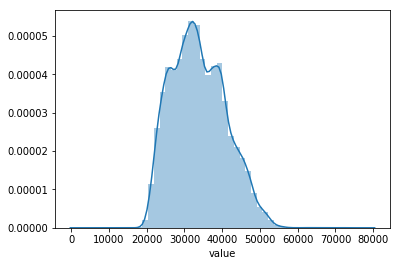

In [372]:
sns.distplot(demand.value)

In [375]:
np.mean(demand.value)

33805.83102165127

In [444]:
res = helper1.score_summary()
# res.sort_values('mean_test_neg_mean_squared_error', ascending = False)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__n_estimators,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,mean_test_r2,std_test_r2,rank_test_r2,estimator
0,3999.819764,3316.040596,7.051023,1.655854,16,{'estimator__n_estimators': 16},-1955.226762,-1869.282443,-1912.254603,42.972159,1,-7.916911e+06,-6.396396e+06,-7.156653e+06,760257.151781,1,0.829147,0.860598,0.844872,0.015726,1,RandomForestRegressor


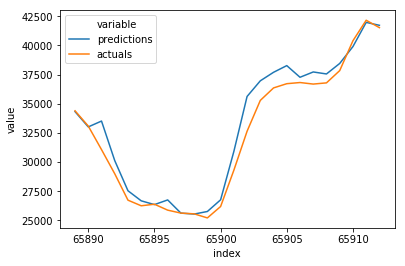

In [457]:
# helper1.grid_searches.best_estimator_
predictions = helper1.grid_searches['RandomForestRegressor'].best_estimator_.predict(X[-1].reshape(1,-1))
predictions = list(reversed(predictions.tolist()[0]))
answer = pd.DataFrame({'predictions':predictions,'actuals':demand.tail(24).value}).reset_index().melt(id_vars=['index'])
# answer
sns.lineplot(data=answer, x='index',hue='variable',y='value')

In [262]:
for dat in [demand, offshore, onshore, solar]:
    X = dat.drop(columns='value')
    y = dat.value
    helper = EstimatorSelectionHelper(models, params, scoring=['neg_mean_absolute_error','neg_mean_squared_error','neg_median_absolute_error','r2'])
    helper.fit(X, y, n_jobs=2)
    display(hetlper.score_summary())

Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   37.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   11.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingRegressor.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    9.6s finished
/Users/b1017579/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,estimator,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2,param_learning_rate,param_n_estimators,params,rank_test_neg_mean_absolute_error,rank_test_neg_mean_squared_error,rank_test_neg_median_absolute_error,rank_test_r2,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split0_test_neg_median_absolute_error,split0_test_r2,split1_test_neg_mean_absolute_error,split1_test_neg_mean_squared_error,split1_test_neg_median_absolute_error,split1_test_r2,split2_test_neg_mean_absolute_error,split2_test_neg_mean_squared_error,split2_test_neg_median_absolute_error,split2_test_r2,std_fit_time,std_score_time,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,ExtraTreesRegressor,2.632686,0.441490,-542.228369,-8.483815e+05,-376.780382,0.981130,NaN,16,{'n_estimators': 16},2,2,2,2,-498.449361,-9.781938e+05,-335.203125,0.979252,-620.695653,-1.014893e+06,-438.651042,0.977024,-507.540093,-5.520577e+05,-356.486979,0.987114,1.314497,0.030168,55.608731,2.100676e+05,44.603696,0.004328
1,ExtraTreesRegressor,5.054057,0.647648,-511.869298,-7.662268e+05,-356.953299,0.982966,NaN,32,{'n_estimators': 32},1,1,1,1,-468.192153,-8.990215e+05,-313.408854,0.980931,-580.853976,-9.080857e+05,-408.789062,0.979442,-486.561766,-4.915731e+05,-348.661979,0.988526,2.413776,0.109250,49.352642,1.942447e+05,39.377705,0.003978
0,RandomForestRegressor,6.864087,0.343211,-551.337493,-8.964676e+05,-377.039931,0.980062,NaN,16,{'n_estimators': 16},2,2,2,2,-506.724348,-1.035396e+06,-332.903646,0.978038,-626.623701,-1.074480e+06,-433.729167,0.975675,-520.664430,-5.795268e+05,-364.486979,0.986473,3.251460,0.108059,53.538717,2.246782e+05,42.108027,0.004635
1,RandomForestRegressor,12.338357,0.509968,-531.920162,-8.305871e+05,-370.380642,0.981530,NaN,32,{'n_estimators': 32},1,1,1,1,-486.284705,-9.648555e+05,-329.644531,0.979535,-607.322292,-9.904271e+05,-424.958333,0.977578,-502.153488,-5.364786e+05,-356.539062,0.987478,5.370033,0.015350,53.709500,2.082280e+05,40.123744,0.004281
0,AdaBoostRegressor,2.045309,0.135307,-1776.371193,-5.386256e+06,-1430.128579,0.879336,NaN,16,{'n_estimators': 16},1,1,1,1,-1746.087308,-5.421096e+06,-1391.751672,0.885014,-1740.394650,-5.160358e+06,-1394.954330,0.883175,-1842.631622,-5.577314e+06,-1503.679733,0.869819,1.164024,0.006067,46.910801,1.719952e+05,52.024953,0.006771
1,AdaBoostRegressor,3.213467,0.261934,-2128.140143,-7.870238e+06,-1718.738702,0.822516,NaN,32,{'n_estimators': 32},2,2,2,2,-1823.478892,-5.918349e+06,-1462.624022,0.874467,-2215.675758,-8.603013e+06,-1744.821411,0.805237,-2345.265779,-9.089352e+06,-1948.770672,0.787844,1.422901,0.070297,221.829141,1.394402e+06,199.323643,0.037415
0,GradientBoostingRegressor,1.040243,0.082828,-857.717902,-1.510763e+06,-679.999666,0.966323,0.8,16,"{'learning_rate': 0.8, 'n_estimators': 16}",3,3,3,3,-833.547369,-1.746596e+06,-639.904303,0.962953,-857.574665,-1.476393e+06,-679.313270,0.966576,-882.031671,-1.309301e+06,-720.781426,0.969439,0.418912,0.012612,19.793893,1.801716e+05,33.021515,0.002654
1,GradientBoostingRegressor,1.581517,0.092699,-724.940792,-1.278563e+06,-553.261330,0.971544,0.8,32,"{'learning_rate': 0.8, 'n_estimators': 32}",1,1,1,1,-711.293748,-1.479393e+06,-517.863157,0.968621,-745.185173,-1.437188e+06,-571.879167,0.967464,-718.343455,-9.191080e+05,-570.041667,0.978547,0.706951,0.010150,14.601388,2.547565e+05,25.041527,0.004974
2,GradientBoostingRegressor,0.825647,0.073750,-879.051901,-1.627104e+06,-682.566420,0.963749,1,16,"{'learning_rate': 1.0, 'n_estimators': 16}",4,4,4,4,-847.238105,-1.890407e+06,-637.933588,0.959903,-898.674928,-1.645085e+06,-688.982487,0.962757,-891.242670,-1.345820e+06,-720.783184,0.968587,0.375436,0.001136,22.699454,2.226903e+05,34.126122,0.003614
3,GradientBoostingRegressor,1.505080,0.081570,-751.089971,-1.364556e+06,-563.193376,0.969658,1,32,"{'learning_rate': 1.0, 'n_estimators': 32}",2,2

Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  4.7min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingRegressor.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   51.4s finished


,estimator,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2,param_learning_rate,param_n_estimators,params,rank_test_neg_mean_absolute_error,rank_test_neg_mean_squared_error,rank_test_neg_median_absolute_error,rank_test_r2,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split0_test_neg_median_absolute_error,split0_test_r2,split1_test_neg_mean_absolute_error,split1_test_neg_mean_squared_error,split1_test_neg_median_absolute_error,split1_test_r2,split2_test_neg_mean_absolute_error,split2_test_neg_mean_squared_error,split2_test_neg_median_absolute_error,split2_test_r2,std_fit_time,std_score_time,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,ExtraTreesRegressor,19.006851,3.925806,-0.009907,-0.000201,-0.006878,0.996597,NaN,16,{'n_estimators': 16},2,2,2,2,-0.010126,-0.000210,-0.007025,0.996563,-0.009904,-0.000200,-0.006894,0.996606,-0.009692,-0.000193,-0.006716,0.996622,10.665520,1.126955,0.000177,6.926731e-06,0.000127,0.000025
1,ExtraTreesRegressor,31.549087,7.739782,-0.009696,-0.000194,-0.006727,0.996717,NaN,32,{'n_estimators': 32},1,1,1,1,-0.009894,-0.000202,-0.006869,0.996693,-0.009721,-0.000193,-0.006761,0.996716,-0.009475,-0.000186,-0.006550,0.996744,12.222690,2.017038,0.000172,6.485039e-06,0.000132,0.000021
0,RandomForestRegressor,44.734570,3.119062,-0.009809,-0.000197,-0.006815,0.996656,NaN,16,{'n_estimators': 16},2,2,2,2,-0.010021,-0.000206,-0.006987,0.996628,-0.009800,-0.000195,-0.006839,0.996677,-0.009605,-0.000190,-0.006619,0.996663,22.429399,0.724040,0.000170,6.323963e-06,0.000151,0.000020
1,RandomForestRegressor,88.206317,7.440520,-0.009606,-0.000191,-0.006647,0.996769,NaN,32,{'n_estimators': 32},1,1,1,1,-0.009823,-0.000199,-0.006823,0.996743,-0.009595,-0.000189,-0.006648,0.996781,-0.009400,-0.000184,-0.006468,0.996783,40.758179,2.981410,0.000173,6.217408e-06,0.000145,0.000019
0,AdaBoostRegressor,15.011655,1.016969,-0.023657,-0.000920,-0.019272,0.984383,NaN,16,{'n_estimators': 16},1,2,1,2,-0.023934,-0.000933,-0.019667,0.984695,-0.023409,-0.000903,-0.019062,0.984659,-0.023629,-0.000925,-0.019087,0.983794,5.147830,0.331578,0.000215,1.298737e-05,0.000280,0.000417
1,AdaBoostRegressor,28.628861,1.335711,-0.023971,-0.000917,-0.020069,0.984442,NaN,32,{'n_estimators': 32},2,1,2,1,-0.023842,-0.000917,-0.019776,0.984964,-0.024045,-0.000915,-0.020252,0.984442,-0.024026,-0.000918,-0.020179,0.983921,11.647915,0.098721,0.000092,9.402897e-07,0.000209,0.000426
0,GradientBoostingRegressor,7.316494,0.611531,-0.015225,-0.000414,-0.011810,0.992986,0.8,16,"{'learning_rate': 0.8, 'n_estimators': 16}",3,3,3,3,-0.015512,-0.000431,-0.011992,0.992932,-0.015130,-0.000405,-0.011826,0.993113,-0.015033,-0.000404,-0.011614,0.992914,2.972392,0.245241,0.000207,1.241108e-05,0.000155,0.000090
1,GradientBoostingRegressor,8.488066,0.435283,-0.013256,-0.000325,-0.010003,0.994488,0.8,32,"{'learning_rate': 0.8, 'n_estimators': 32}",1,1,1,1,-0.013235,-0.000326,-0.009920,0.994654,-0.013381,-0.000328,-0.010172,0.994422,-0.013153,-0.000320,-0.009917,0.994388,3.050374,0.006121,0.000095,3.346435e-06,0.000119,0.000118
2,GradientBoostingRegressor,3.982850,0.380933,-0.015414,-0.000425,-0.011875,0.992779,1,16,"{'learning_rate': 1.0, 'n_estimators': 16}",4,4,4,4,-0.015205,-0.000416,-0.011704,0.993180,-0.015684,-0.000438,-0.012137,0.992550,-0.015355,-0.000422,-0.011785,0.992608,1.683491,0.009158,0.000200,9.493239e-06,0.000188,0.000285
3,GradientBoostingRegressor,7.307419,0.413714,-0.013457,-0.000334,-0.010192,0.994330,1,32,"{'learning_rate': 1.0, 'n_estimators': 32}",2,2,2,2,-0.013281,-0.000326,-0.010066,0.994657,-0.013590,-0.000339,-0.010357,0.994246,-0.013500,-0.000337,-0.010155,0.994087,3.144303,0.026680,0.000130,5.745331e-06,0.000122,0.000240


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  3.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   57.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingRegressor.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:  1.1min finished


,estimator,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2,param_learning_rate,param_n_estimators,params,rank_test_neg_mean_absolute_error,rank_test_neg_mean_squared_error,rank_test_neg_median_absolute_error,rank_test_r2,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split0_test_neg_median_absolute_error,split0_test_r2,split1_test_neg_mean_absolute_error,split1_test_neg_mean_squared_error,split1_test_neg_median_absolute_error,split1_test_r2,split2_test_neg_mean_absolute_error,split2_test_neg_mean_squared_error,split2_test_neg_median_absolute_error,split2_test_r2,std_fit_time,std_score_time,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,ExtraTreesRegressor,17.050249,3.437569,-0.008591,-0.000158,-0.005736,0.996148,NaN,16,{'n_estimators': 16},2,2,2,2,-0.008988,-0.000172,-0.006015,0.995965,-0.008520,-0.000155,-0.005715,0.996091,-0.008264,-0.000147,-0.005479,0.996386,8.215497,0.344905,0.000300,0.000011,0.000219,0.000177
1,ExtraTreesRegressor,37.012263,7.933394,-0.008379,-0.000152,-0.005540,0.996292,NaN,32,{'n_estimators': 32},1,1,1,1,-0.008750,-0.000166,-0.005806,0.996122,-0.008316,-0.000149,-0.005511,0.996239,-0.008071,-0.000142,-0.005302,0.996514,17.989475,2.907657,0.000281,0.000010,0.000207,0.000164
0,RandomForestRegressor,30.673976,2.339840,-0.008516,-0.000156,-0.005641,0.996191,NaN,16,{'n_estimators': 16},2,2,2,2,-0.008901,-0.000171,-0.005909,0.995997,-0.008441,-0.000152,-0.005603,0.996157,-0.008206,-0.000146,-0.005411,0.996420,13.676722,0.452749,0.000289,0.000011,0.000205,0.000174
1,RandomForestRegressor,59.903168,4.061705,-0.008335,-0.000151,-0.005478,0.996319,NaN,32,{'n_estimators': 32},1,1,1,1,-0.008707,-0.000165,-0.005742,0.996144,-0.008277,-0.000148,-0.005442,0.996266,-0.008020,-0.000141,-0.005249,0.996547,27.462339,0.388982,0.000283,0.000010,0.000203,0.000169
0,AdaBoostRegressor,11.022767,0.673887,-0.019737,-0.000655,-0.015822,0.984000,NaN,16,{'n_estimators': 16},1,1,1,1,-0.019871,-0.000662,-0.016084,0.984510,-0.020099,-0.000675,-0.016223,0.982950,-0.019239,-0.000630,-0.015159,0.984540,4.796405,0.037928,0.000364,0.000019,0.000472,0.000743
1,AdaBoostRegressor,18.068371,1.062537,-0.020504,-0.000670,-0.017228,0.983672,NaN,32,{'n_estimators': 32},2,2,2,2,-0.021141,-0.000702,-0.018004,0.983560,-0.020450,-0.000665,-0.017146,0.983182,-0.019921,-0.000641,-0.016534,0.984274,7.927591,0.123914,0.000499,0.000025,0.000603,0.000453
0,GradientBoostingRegressor,3.948676,0.372561,-0.012913,-0.000313,-0.009525,0.992375,0.8,16,"{'learning_rate': 0.8, 'n_estimators': 16}",3,3,3,3,-0.012954,-0.000319,-0.009457,0.992533,-0.012985,-0.000313,-0.009664,0.992090,-0.012799,-0.000306,-0.009455,0.992503,1.770974,0.010319,0.000081,0.000005,0.000098,0.000202
1,GradientBoostingRegressor,7.549160,0.503995,-0.011379,-0.000248,-0.008272,0.993943,0.8,32,"{'learning_rate': 0.8, 'n_estimators': 32}",1,1,1,1,-0.011397,-0.000251,-0.008209,0.994129,-0.011481,-0.000251,-0.008376,0.993649,-0.011260,-0.000242,-0.008230,0.994053,3.372051,0.127091,0.000091,0.000004,0.000075,0.000211
2,GradientBoostingRegressor,6.947820,0.409754,-0.013195,-0.000326,-0.009722,0.992053,1,16,"{'learning_rate': 1.0, 'n_estimators': 16}",4,4,4,4,-0.013468,-0.000341,-0.009938,0.992019,-0.013112,-0.000324,-0.009567,0.991813,-0.013004,-0.000313,-0.009663,0.992328,3.592601,0.065025,0.000198,0.000012,0.000157,0.000212
3,GradientBoostingRegressor,12.372489,0.684061,-0.011593,-0.000257,-0.008424,0.993737,1,32,"{'learning_rate': 1.0, 'n_estimators': 32}",2,2,2,2,-0.011759,-0.000265,-0.008546,0.993791,-0.011681,-0.000257,-0.008524,0.993499,-0.011339,-0.000248,-0.008203,0.993920,7.599694,0.198233,0.000182,0.000007,0.000156,0.000176


Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostRegressor.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:   53.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingRegressor.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:   37.5s finished


,estimator,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2,param_learning_rate,param_n_estimators,params,rank_test_neg_mean_absolute_error,rank_test_neg_mean_squared_error,rank_test_neg_median_absolute_error,rank_test_r2,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split0_test_neg_median_absolute_error,split0_test_r2,split1_test_neg_mean_absolute_error,split1_test_neg_mean_squared_error,split1_test_neg_median_absolute_error,split1_test_r2,split2_test_neg_mean_absolute_error,split2_test_neg_mean_squared_error,split2_test_neg_median_absolute_error,split2_test_r2,std_fit_time,std_score_time,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,ExtraTreesRegressor,15.708273,3.390402,-0.003848,-0.000058,-0.000208,0.997822,NaN,16,{'n_estimators': 16},2,2,2,2,-0.004047,-0.000063,-0.000223,0.997597,-0.003810,-0.000057,-0.000194,0.997836,-0.003686,-0.000053,-0.000207,0.998032,6.448401,1.011202,0.000150,0.000004,0.000012,0.000178
1,ExtraTreesRegressor,14.409080,2.437239,-0.003738,-0.000055,-0.000202,0.997930,NaN,32,{'n_estimators': 32},1,1,1,1,-0.003894,-0.000059,-0.000209,0.997754,-0.003716,-0.000054,-0.000197,0.997928,-0.003603,-0.000051,-0.000200,0.998108,4.630697,0.369062,0.000120,0.000003,0.000005,0.000145
0,RandomForestRegressor,12.439532,0.984190,-0.003903,-0.000059,-0.000218,0.997755,NaN,16,{'n_estimators': 16},2,2,2,2,-0.004085,-0.000065,-0.000231,0.997518,-0.003891,-0.000059,-0.000206,0.997759,-0.003731,-0.000054,-0.000217,0.997987,5.668179,0.159709,0.000145,0.000005,0.000010,0.000191
1,RandomForestRegressor,25.017198,1.634999,-0.003820,-0.000057,-0.000216,0.997846,NaN,32,{'n_estimators': 32},1,1,1,1,-0.004008,-0.000063,-0.000230,0.997616,-0.003783,-0.000056,-0.000209,0.997870,-0.003668,-0.000052,-0.000208,0.998052,11.497519,0.190096,0.000142,0.000004,0.000010,0.000179
0,AdaBoostRegressor,11.261415,0.586122,-0.017123,-0.000631,-0.006607,0.976098,NaN,16,{'n_estimators': 16},1,2,1,2,-0.017579,-0.000598,-0.008377,0.977264,-0.017844,-0.000674,-0.007342,0.974281,-0.015948,-0.000622,-0.004102,0.976748,5.408045,0.020432,0.000838,0.000032,0.001821,0.001302
1,AdaBoostRegressor,16.493768,1.000921,-0.020915,-0.000620,-0.015672,0.976549,NaN,32,{'n_estimators': 32},2,1,2,1,-0.020897,-0.000602,-0.016420,0.977099,-0.020309,-0.000608,-0.014062,0.976810,-0.021541,-0.000649,-0.016534,0.975738,4.963543,0.167010,0.000503,0.000021,0.001139,0.000585
0,GradientBoostingRegressor,3.133151,0.314721,-0.009327,-0.000280,-0.001054,0.989401,0.8,16,"{'learning_rate': 0.8, 'n_estimators': 16}",4,4,1,4,-0.009075,-0.000261,-0.001051,0.990066,-0.009752,-0.000296,-0.001333,0.988723,-0.009154,-0.000283,-0.000777,0.989413,1.549833,0.007532,0.000302,0.000014,0.000227,0.000548
1,GradientBoostingRegressor,6.339025,0.387064,-0.007448,-0.000182,-0.001552,0.993116,0.8,32,"{'learning_rate': 0.8, 'n_estimators': 32}",2,2,4,2,-0.007414,-0.000185,-0.001801,0.992977,-0.007520,-0.000184,-0.001546,0.992981,-0.007410,-0.000177,-0.001308,0.993389,3.274190,0.004905,0.000051,0.000004,0.000202,0.000194
2,GradientBoostingRegressor,3.544334,0.324653,-0.008641,-0.000245,-0.001465,0.990742,1,16,"{'learning_rate': 1.0, 'n_estimators': 16}",3,3,3,3,-0.008594,-0.000238,-0.002075,0.990943,-0.008472,-0.000242,-0.001053,0.990782,-0.008857,-0.000254,-0.001266,0.990501,1.825269,0.005316,0.000161,0.000007,0.000440,0.000182
3,GradientBoostingRegressor,5.684604,0.405468,-0.007169,-0.000175,-0.001379,0.993376,1,32,"{'learning_rate': 1.0, 'n_estimators': 32}",1,1,2,1,-0.006927,-0.000167,-0.001396,0.993652,-0.007172,-0.000172,-0.001477,0.993423,-0.007409,-0.000186,-0.001265,0.993052,2.210399,0.086747,0.000197,0.000008,0.000087,0.000247
